# Data Cleaning & Feature Extraction

In this notebook, load the different data sources explored earlier and clean them for our approaches. We will then create a very basic predicition system to check for 

In [2]:
import pandas as pd
import numpy as np
import sys, os
from datetime import datetime
sys.path.insert(1, '..')
import recommender as rcmd
%matplotlib inline

Next we will load a set of relevant data sources

In [2]:
nf = rcmd.news.FPNewsFeed('https://www.ft.com/business-education?format=rss', col_map={'link': 'article_link', 'summary': 'summary', 'title': 'headline', 'published': 'date'}, filter=True)
news_meta, df_news = nf.news()
sm = rcmd.stocks.FMPStatements()
tk = rcmd.stocks.AlphaVantageTicker()
df_stocks = rcmd.contrib.fmp_api.profile.list_symbols()

In [30]:
df_stocks['symbol'].values

array(['SPY', 'CMCSA', 'KMI', ..., 'ZWZZT', 'ZXZZT', 'ZYME'], dtype=object)

## Data Extraction Pipeline

Our goal will be to create a pipeline that can extract data for a specific stock we select from `df_stocks`. This includes the last balance-sheet statements as well as historic stock prices. We should also search for historic news that we can use for the training process.

In [38]:
def find_stock(name, stocks):
    return stocks[stocks['name'].str.contains(name, case=False)]

find_stock('facebook', df_stocks)

,name,price,symbol
21,Facebook Inc.,188.2,FB


In [57]:
# some stock selection functions (this gathers all available data and might take a while...)
#df = sm.merge_records(df_stocks['symbol'].values)
#df.to_csv('../data/statements.csv')

# load the relevant data
df = pd.read_csv('../data/statements.csv')

In [61]:
# create an index based on year and quarter
df['date'] = df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
df['year'] = df['date'].dt.year
df['quarter'] = df['date'].dt.quarter

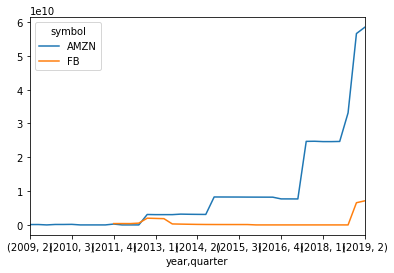

In [76]:
# print out example data
def get_feature(symbol, feat):
    return df[df['symbol'] == symbol].set_index(['year', 'quarter'])[feat].rename(symbol).sort_index(ascending=True)

def get_features(symbols, feat):
    return df[df['symbol'].isin(symbols)].pivot_table(index=['year', 'quarter'], columns='symbol', values=feat).sort_index(ascending=True)

# plot features
get_features(['FB', 'AMZN'], 'debt_longterm').plot()

**Stock Data**

Now that we have loaded the relevant Stock Statements, lets load the historical stock data (daily resolution) - in this case loading from file (requires that the `data/download_stocks.sh` script has been executed.

,Date,Open,High,Low,Close,Volume,OpenInt
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0


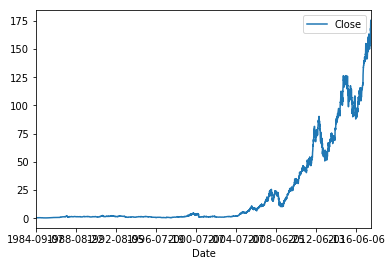

In [2]:
import glob
import os
def list_stocks(type='stock'):
    '''Generates a list of available historic stock data.'''
    fldr = 'Stocks' if type == 'stock' else 'ETFs'
    path = '../data/{}'.format(fldr)
    # list all fiels in direcotry
    files = glob.glob(os.path.join(path, '*.txt'))
    names = pd.Series(files).apply(lambda f: os.path.basename(f).split('.')[0])
    #return pd.DataFrame({'symbol': names, 'file': files})
    return dict(zip(names, files))

def load_stock_file(file, type='stock'):
    # list all fiels in direcotry
    return pd.read_csv(file)
    
stocks = list_stocks('stock')
#stocks
dfa = pd.read_csv(stocks['aapl'])
dfa.set_index('Date')[['Close']].plot();
dfa.head()

In [3]:
# sample list of stock elements
sample = np.random.choice(list(stocks.keys()), 30)
#sample = list(stocks.keys())[:10]

# Note: integrated into the cache class in the recommender
def load_stock_list(symbols, stocks=None, ticker=None):
    '''Loads a dataframe with the given stock data.
    
    Args:
        symbols (list): List of symbol names to load
        stocks (dict): Stock name dictionary (if None, load with default vals)
        
    Returns:
        DataFrame in default stock format with additional symbol column
    '''
    df_stocks = []
    for symbol in symbols:
        # load stock data
        if symbol in stocks:
            try:
                df_stock = pd.read_csv(stocks[symbol])
            except:
                continue
        else:
            try:
                df_stock = ticker.historic(symbol, start=None, resolution='daily').reset_index()
            except:
                print('Could not load {}'.format(symbol))
                continue
            
        # check if empty
        if df_stock is None or df_stock.empty == True:
            continue
        
        # add
        df_stock['symbol'] = symbol
        df_stock.columns = [col.lower() for col in df_stock.columns]
        df_stocks.append(df_stock)
    
    
    df = pd.concat(df_stocks, axis=0)
    return df

df_stocks = load_stock_list(sample, stocks, ticker=rcmd.stocks.AlphaVantageTicker())
df_stocks.sample(10)

,date,open,high,low,close,volume,openint,symbol
1548,1998-03-31,4.57950,4.61230,4.51410,4.51410,1155596,0,msa
1832,2012-06-06,17.26700,17.73700,17.24200,17.73700,35226,0,nrt
1311,2010-05-13,14.89600,14.98600,14.60400,14.98600,51363,0,fisi
346,2016-03-28,40.40000,40.96000,39.72000,40.70000,329963,0,incr
1925,2012-10-25,4.32740,4.39550,4.29820,4.31770,15048,0,eman
2374,2014-08-04,103.21000,104.20000,102.66000,104.11000,437906,0,lh
888,2008-09-08,15.00900,15.02400,13.93400,14.13000,37160,0,fisi
928,2008-11-06,0.36953,0.38898,0.23339,0.35008,179544,0,eman
2414,2014-12-29,13.39600,13.51900,13.33400,13.40400,1334470,0,drh
2948,2017-02-10,10.98800,10.98800,10.88600,10.92100,1951795,0,drh


In [ ]:
# TODO: select historic news and scrap entire news articles? + Use Embeddings to integrate them

## Feature Extraction

After we have loaded the data and can extract relevant portions, we want to convert it into training data. This requires data to have a single embedding and to use structured time information. As well as combine past data with future performance to have labels for the training process.

The goal of the stock prediction system is to use current information:

* Last Statements from a given company
* Recent stock history

To predict the outcome of the stock data (i.e. would an invest in the stock be profitable over time horizon X). This leaves us with the following parameters for the data training:

1. Time Horizon of prediction (How long do we want to look in the future?)
2. Amount of Recent Data (Do we just give the current state of a windows of data from the past X days/month?)
3. Cliping of target values (in which interval is a stock profitable, neutral or unprofitable?)
3. Normalization of the Data (Do we use absolute values of differences?)
4. Smoothing of the Data (Do we take the stock closing price on a single day or of a week?)

The last two questions are probably easiest to answer. Since all stocks have different values (i.e. different start prices of the stock and current statement values) and these values do not have an impact on our prediction (if a \\$10 stock rises to \\$200 this is a much better investment than a \\$1000 stocks rise to \\$1500). We will therefore adopt a normalization that takes the current stock price as a starting point and computes percental difference from there. This will provide a normalized scale across all stocks.

For the smoothing we might use a time windows that is dependent on the length of the prediction (e.g. +/- 3 days for a quarter prediction and +/- 1 Week for a year prediction).

To verify this, we will write a function to normalize the data and given a time horizon create a distribution of the target values

In [8]:
df_test = pd.DataFrame(np.random.randn(21, 3))
b = 3
t = 3
s = 1
as_strided = np.lib.stride_tricks.as_strided
win = b+t+s

df_test = df_test.iloc[:, 0:1]

idx = np.arange(0, len(df_test))
print(df_test.values)

#print(df_test)
st = df_test.values.strides
print(st)
every = 7
# TODO: update length calculation (make sure the bytes do not jump out of index)
sz = np.ceil((len(df_test) - (win-1)) / every)
arr = as_strided(df_test, (int(sz), win), (st[0] * every, st[1] * 1))
print(arr)

cols = ["day_{}".format(i+1) for i in range(b)] + ["day_target_{}".format(b + t)]

df = np.apply_along_axis(lambda wnd: normalize_window(wnd, b, t, s), axis=1, arr=arr)

df = pd.DataFrame(df)
idx = idx[:-(win-1)][0::every]
df.index = idx
df.columns = cols
df

[[-9.83716752e-01]
 [-4.27447883e-04]
 [-1.68081978e+00]
 [ 1.07749071e+00]
 [ 1.49498458e+00]
 [-2.20385997e-01]
 [-9.47433019e-02]
 [ 8.21892370e-01]
 [ 2.64676026e-01]
 [-9.38890484e-01]
 [-6.71343937e-01]
 [-1.60541257e+00]
 [-6.28585255e-01]
 [-9.82462156e-01]
 [-3.92343991e-01]
 [ 4.48298626e-01]
 [-1.20475642e+00]
 [-7.66332724e-01]
 [-5.13942168e-01]
 [-3.78372744e-01]
 [-1.70079121e+00]]
(24, 8)
[[-9.83716752e-01 -2.20829506e+00  1.24137138e+00 -4.27447883e-04
   4.68281834e-01 -2.56510702e-02 -1.68081978e+00]
 [ 8.21892370e-01 -1.36390658e+00  3.02252684e-01  2.64676026e-01
  -1.84025335e+00  1.25109978e+00 -9.38890484e-01]
 [-3.92343991e-01 -1.61578497e+00 -4.47916487e-01  4.48298626e-01
   1.50798616e+00  6.40298586e-01 -1.20475642e+00]]


NameError: name 'normalize_window' is not defined

In [11]:
# Function to align the statements of a company with the 
def normalize_window(df, days_back, days_target, smooth_interval):
    '''Normalizes the data in the given window and returns the values and the target
    
    Args:
        df (np.Array): Numpy Array that contains only one values column
        days_back (int): How many days of history data should be included
        days_target (int): How many days shoudl the target value lie ahead
        smooth_interval (int): Interval in days around the target value that is used for smoothing (if None use just target day)
        
    Returns:
        Numpy array that has the normalized data of length `days_back` and an additional datapoint with the target value
    '''
    # retrieve the normalized data
    norm = df[days_back - 1]
    df = ((df - norm)  / norm)
    
    # retrieve the input stock values
    vals = df[:days_back]
    # TODO: might call additional compaction (e.g. only weekly data)
    
    # calculate the target value
    target_loc = days_back + days_target - 1
    if smooth_interval is None:
        target = df[target_loc]
    else:
        target = df[(target_loc - smooth_interval):(target_loc + smooth_interval + 1)].mean()
    
    # return result vector
    return np.concatenate([vals, [target]])
    
# alias for numpy function
as_strided = np.lib.stride_tricks.as_strided
    
def create_dataset(df, days_back, days_target, smooth_interval, value_col='close', jump_size=7):
    '''Creates a dataset from the given stock data.
    
    Args:
        df (DataFrame): DataFrame of stock prices. Each Row should contain these columns: `[symbol, date, values]`
        value_col (str): Name of the column that contains the relevant stock data
        days_back (int): How many days of history data should be included
        days_target (int): How many days shoudl the target value lie ahead
        smooth_interval (int): Interval in days around the target value that is used for smoothing
        jump_size (int): Number of days to jump between different data points
    
    Returns:
        DataFrame that should contain the relevant stock information. It contains the following columns: `[date, *data, target, symbol]`.
        `date` is thereby the starting date before the prediction.
        `data` are a list of columns from newest to oldest (number is defined by `days_back`)
           |------------------|----------------------------|
         date    data    date+days_back                 target
    '''
    # iterate through all symbols in the df
    symbols = df['symbol'].unique()
    # make sure that date column is converted
    if df['date'].dtype == 'object':
        df['date'] = df['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
        
    # calculate window size and the column names
    win = days_back + days_target + (smooth_interval if smooth_interval is not None else 0)
    cols = ["day_{}".format(i+1) for i in range(days_back)] + ["target"]
    
    # order symbol-df for time and perform sliding window
    df_symbol = df['symbol'].str.lower()
    df_norm = []
    for symbol in symbols:
        # retrieve partial df
        df_sym = df[df_symbol == symbol.lower()].sort_values(by='date')[[value_col]]
        
        # sliding window
        st = df_sym.values.strides   # number of bytes for as_stride to jump
        sz = np.ceil((len(df_sym) - (win-1)) / jump_size)
        wnds = as_strided(df_sym, (int(sz), win), (st[0] * jump_size, st[1] * 1))

        # apply normalization
        df_res = np.apply_along_axis(lambda wnd: normalize_window(wnd, days_back, days_target, smooth_interval), axis=1, arr=wnds)
        df_res = pd.DataFrame(df_res)
        
        # add columns and index
        df_res.columns = cols
        df_res.index = df_sym.index[:-(win-1)][0::jump_size]
        df_res['symbol'] = symbol
        
        # add to result
        df_norm.append(df_res)
    
    # add data to target
    df_norm = pd.concat(df_norm, axis=0)
    
    return df_norm

In [ ]:
df_norm = create_dataset(df_stocks, 7, 30, 3)
df_norm.head()

Next we should understand what we actually want to measure. 

In [26]:
df['date'].head()

0    2019-06-30
1    2019-03-31
2    2018-12-31
3    2018-09-30
4    2018-06-30
Name: date, dtype: object

In [86]:
df[df['symbol'].str.lower() == 'aapl'.lower()].sort_values(by='date')

,Unnamed: 0,assets_tax,assets_total,assets_total_current,assets_total_noncurrent,buybacks,capital_expenditure,cash_marketcap_ratio,cashflow_finance,cashflow_free,...,liability_deposit,liability_tax,liability_total,revenue,revenue_costs,revenue_deffered,revenue_growth,symbol,year,quarter
282,40,1.731000e+09,4.814000e+10,1.297000e+10,5.591000e+09,1.990000e+08,-3.020000e+08,0.1407,2.080000e+08,1.968000e+09,...,0.0,0.0,2.225200e+10,9.734000e+09,5.751000e+09,1.213600e+10,0.3041,AAPL,2009,2
281,39,1.135000e+09,4.750100e+10,1.594600e+10,4.355000e+09,1.870000e+08,-4.720000e+08,0.1407,3.190000e+08,2.638000e+09,...,0.0,0.0,1.586100e+10,1.220700e+10,7.102000e+09,2.906000e+09,-0.0542,AAPL,2009,3
280,38,1.180000e+09,5.392600e+10,2.059400e+10,5.061000e+09,3.740000e+08,-3.810000e+08,0.0963,5.230000e+08,5.400000e+09,...,0.0,0.0,1.815800e+10,1.568300e+10,9.272000e+09,3.512000e+09,0.3201,AAPL,2009,4
279,37,1.142000e+09,5.705700e+10,2.472100e+10,5.480000e+09,1.600000e+08,-3.010000e+08,0.0963,1.620000e+08,2.029000e+09,...,0.0,0.0,1.770900e+10,1.349900e+10,7.874000e+09,3.483000e+09,0.4860,AAPL,2010,1
278,36,1.216000e+09,6.472500e+10,2.869200e+10,6.002000e+09,1.990000e+08,-6.260000e+08,0.0963,3.160000e+08,4.175000e+09,...,0.0,0.0,2.161400e+10,1.570000e+10,9.564000e+09,3.712000e+09,0.6129,AAPL,2010,2
277,35,1.636000e+09,7.518300e+10,3.350500e+10,6.670000e+09,1.790000e+08,-8.130000e+08,0.0963,2.560000e+08,4.870000e+09,...,0.0,0.0,2.739200e+10,2.034300e+10,1.283100e+10,4.123000e+09,0.6665,AAPL,2010,3
276,34,1.724000e+09,8.674200e+10,4.281500e+10,8.281000e+09,2.080000e+08,-1.263000e+09,0.0906,4.290000e+08,8.510000e+09,...,0.0,0.0,3.207600e+10,2.674100e+10,1.644300e+10,4.757000e+09,0.7051,AAPL,2010,4
275,33,1.683000e+09,9.490400e+10,4.790700e+10,9.100000e+09,2.860000e+08,-6.560000e+08,0.0905,5.470000e+08,5.563000e+09,...,0.0,0.0,3.342700e+10,2.466700e+10,1.444900e+10,4.821000e+09,0.8273,AAPL,2011,1
274,32,1.892000e+09,1.067580e+11,5.986000e+10,1.055600e+10,8.300000e+07,-9.620000e+08,0.0925,3.700000e+07,1.014600e+10,...,0.0,0.0,3.741500e+10,2.857100e+10,1.664900e+10,5.399000e+09,0.8198,AAPL,2011,2
273,31,2.014000e+09,1.163710e+11,7.138300e+10,1.178600e+10,2.540000e+08,-4.571000e+09,0.0694,4.310000e+08,5.858000e+09,...,0.0,0.0,3.975600e+10,2.827000e+10,1.689000e+10,5.777000e+09,0.3897,AAPL,2011,3
